In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use("seaborn-v0_8-dark-palette")

# Plot styling
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.xmargin'] = 0 # Remove margin between plot and y-axis
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (10, 6)  # Fixed: 'figsize' -> 'figure.figsize'

# Spine styling
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Axes styling
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.5

# Title styling
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlepad'] = 20  # Add padding between title and plot

# Label styling
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelpad'] = 10  # Add padding between labels and plot

# Grid styling
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.3

In [2]:
# Load your data
employees = pd.read_csv('employees.csv', parse_dates=['review_date', 'termination_date'])
managers = pd.read_csv('managers.csv')

# ---- 1. Calculate Metrics for Each Manager ----

# TEAM RETENTION RATE: % of active team members (not terminated in last 12 months)
today = pd.Timestamp.now()
twelve_months_ago = today - pd.DateOffset(months=12)

def retention_rate(df, ref_date):
    active = df[(df['terminated'] == 0) | (df['termination_date'] >= ref_date)]
    return len(active) / len(df) if len(df) > 0 else np.nan

retention = employees.groupby('manager_id').apply(
    lambda df: retention_rate(df, twelve_months_ago)
).rename('retention_rate')

# REVIEW TIMELINESS: % reviews “On Time”
timeliness = employees.groupby('manager_id')['review_timeliness'].apply(
    lambda x: (x == 'On Time').mean()
).rename('review_timeliness_pct')

# TEAM PERFORMANCE: Average performance rating (1-5)
performance = employees.groupby('manager_id')['rating'].mean().rename('avg_performance')

# TEAM ENGAGEMENT: Average engagement score
engagement = employees.groupby('manager_id')['engagement_score'].mean().rename('avg_engagement')

# Combine metrics into single DataFrame
metrics = pd.concat([retention, timeliness, performance, engagement], axis=1).reset_index()

# ---- 2. Normalize Metrics (Min-Max 0-1 Scaling) ----
for col in ['retention_rate', 'review_timeliness_pct', 'avg_performance', 'avg_engagement']:
    min_val = metrics[col].min()
    max_val = metrics[col].max()
    if max_val > min_val:
        metrics[f'norm_{col}'] = (metrics[col] - min_val) / (max_val - min_val)
    else:
        metrics[f'norm_{col}'] = 0  # Edge case: all values equal

# ---- 3. Weighted Composite Score ----
metrics['manager_effectiveness_index'] = (
    0.3 * metrics['norm_retention_rate'] +
    0.2 * metrics['norm_review_timeliness_pct'] +
    0.3 * metrics['norm_avg_performance'] +
    0.2 * metrics['norm_avg_engagement']
)

# Optional: Scale index 0–100 for exec summary
metrics['manager_effectiveness_index_100'] = (metrics['manager_effectiveness_index'] * 100).round(2)

# ---- 4. Join Back to Manager Info ----
final = pd.merge(managers, metrics, on='manager_id', how='left')

# ---- 5. Sort & Preview ----
final_sorted = final.sort_values(by='manager_effectiveness_index_100', ascending=False)
print(final_sorted[['manager_id', 'manager_name', 'department', 'level', 'team_size',
                    'manager_effectiveness_index_100']].head(10))

# Save or use for next step
final_sorted.to_csv('manager_effectiveness_results.csv', index=False)


   manager_id manager_name  department   level  team_size  \
63       M263   Manager_63       Sales  Senior         88   
37       M237   Manager_37       Sales  Senior         81   
53       M253   Manager_53       Sales     Mid         93   
64       M264   Manager_64          HR  Senior         69   
12       M212   Manager_12          IT     Mid         74   
15       M215   Manager_15   Analytics    Lead         67   
55       M255   Manager_55   Marketing     Mid         88   
56       M256   Manager_56   Marketing     Mid         94   
26       M226   Manager_26     Product     Mid         93   
27       M227   Manager_27  Operations     Mid        111   

    manager_effectiveness_index_100  
63                            83.35  
37                            76.76  
53                            76.43  
64                            75.64  
12                            73.43  
15                            72.39  
55                            70.96  
56                      

## 1️⃣ Aggregate Manager Effectiveness by Department

In [3]:
# Group by department: mean, min, max, count
dept_summary = final_sorted.groupby('department')['manager_effectiveness_index_100'] \
    .agg(['mean', 'min', 'max', 'count']) \
    .sort_values('mean', ascending=False)
print("\nDepartment summary:\n", dept_summary)



Department summary:
                   mean    min    max  count
department                                 
Sales        68.733333  55.45  83.35      6
HR           58.088750  33.95  75.64      8
Finance      56.674000  48.81  62.79      5
Engineering  56.046000  38.51  65.10      5
Admin        55.595000  46.07  65.24      4
Marketing    55.491667  43.91  70.96      6
Operations   53.861818  44.62  66.44     11
Analytics    53.566250  31.43  72.39      8
IT           50.323333  23.22  73.43      6
Product      49.130000  30.60  67.59      5
Legal        45.450000  45.45  45.45      1


# 2️⃣ Aggregate Manager Effectiveness by Level

In [4]:
# Group by manager level: mean, min, max, count
level_summary = final_sorted.groupby('level')['manager_effectiveness_index_100'] \
    .agg(['mean', 'min', 'max', 'count']) \
    .sort_values('mean', ascending=False)
print("\nManager level summary:\n", level_summary)


Manager level summary:
              mean    min    max  count
level                                 
Mid     55.970698  33.95  76.43     43
Senior  55.878824  30.60  83.35     17
Lead    50.682000  23.22  72.39      5


# 3️⃣ Correlation Between Team Size & Effectiveness

In [5]:
# Pearson correlation between team size and manager effectiveness
corr = final_sorted['team_size'].corr(final_sorted['manager_effectiveness_index_100'])
print(f"\nCorrelation between team size and manager effectiveness: {corr:.2f}")



Correlation between team size and manager effectiveness: -0.06


# 4️⃣ Top & Bottom Managers

In [6]:
# Top 3 managers by effectiveness
top3 = final_sorted.nlargest(3, 'manager_effectiveness_index_100')[['manager_name', 'department', 'level', 'team_size', 'manager_effectiveness_index_100']]
print("\nTop 3 managers:\n", top3)

# Bottom 3 managers by effectiveness
bottom3 = final_sorted.nsmallest(3, 'manager_effectiveness_index_100')[['manager_name', 'department', 'level', 'team_size', 'manager_effectiveness_index_100']]
print("\nBottom 3 managers:\n", bottom3)



Top 3 managers:
    manager_name department   level  team_size  manager_effectiveness_index_100
63   Manager_63      Sales  Senior         88                            83.35
37   Manager_37      Sales  Senior         81                            76.76
53   Manager_53      Sales     Mid         93                            76.43

Bottom 3 managers:
    manager_name department   level  team_size  manager_effectiveness_index_100
46   Manager_46         IT    Lead         91                            23.22
60   Manager_60    Product  Senior        100                            30.60
0     Manager_0  Analytics  Senior         79                            31.43


# 5️⃣ Bar Charts for Department & Level Means

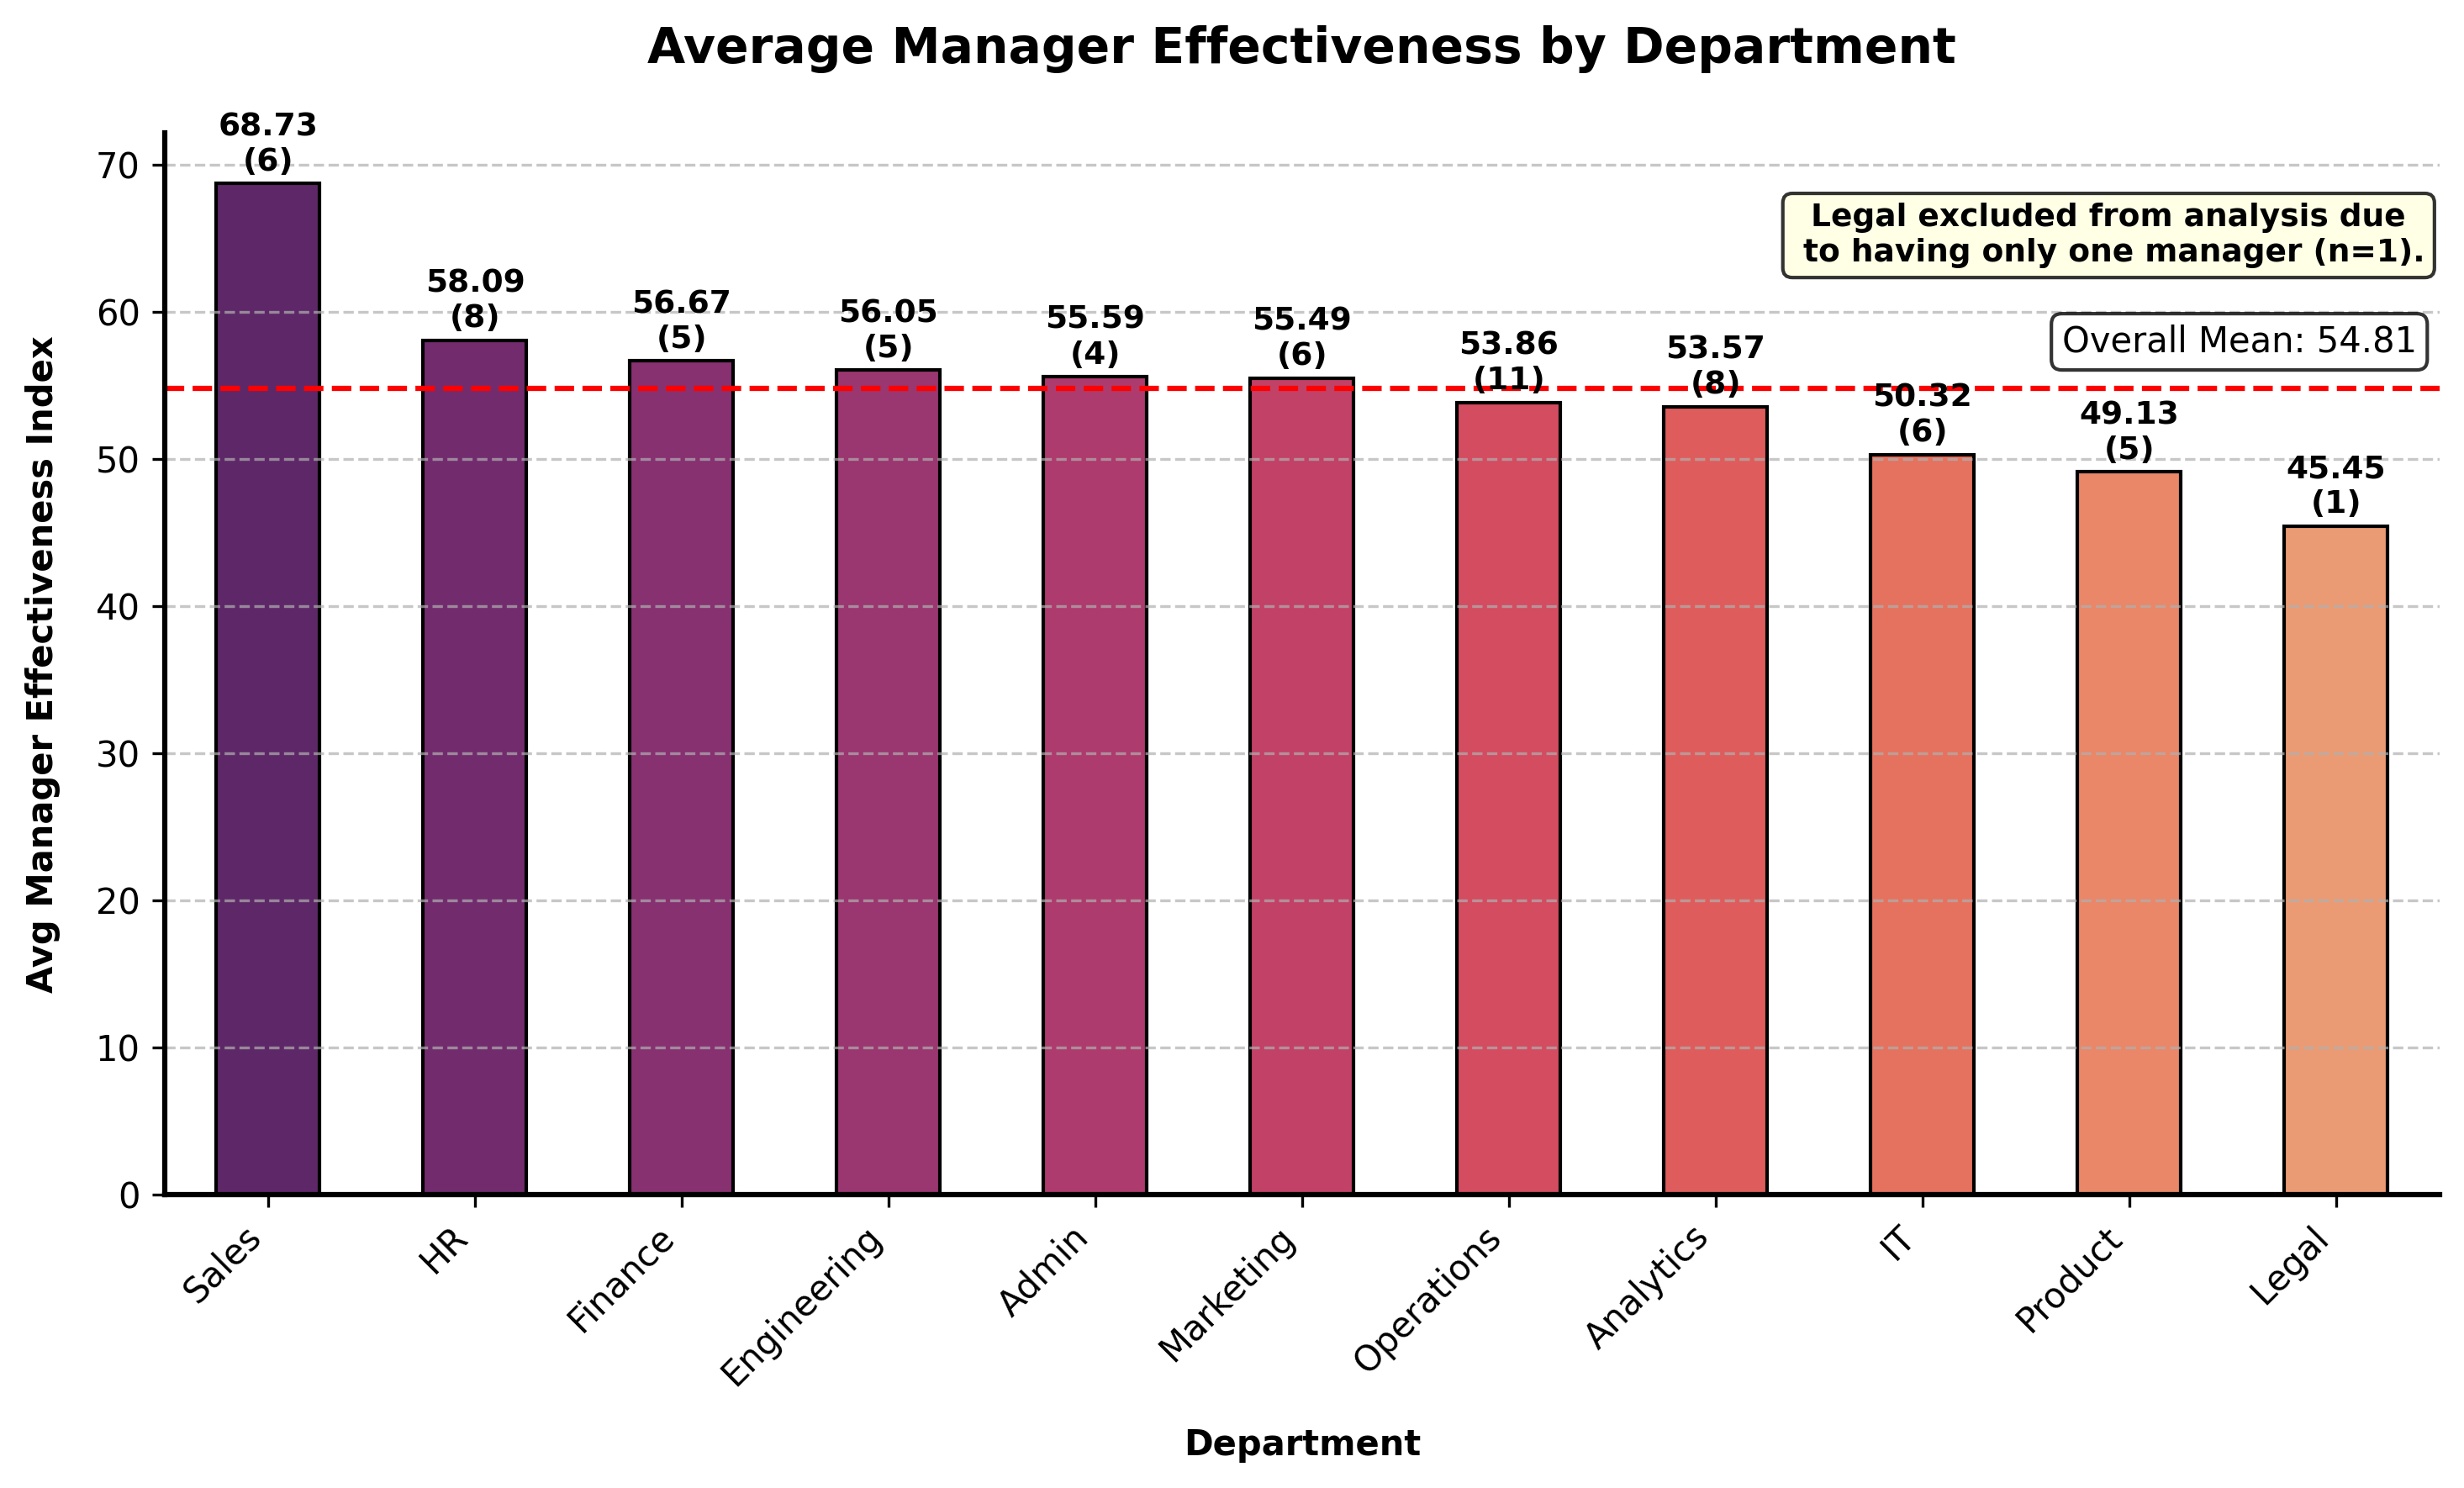

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar Chart: Average manager index by department
bar_colors = sns.color_palette("flare_r", len(dept_summary)) 
fig, ax = plt.subplots()

# Plot the bar chart
dept_summary['mean'].plot(kind='bar', color=bar_colors, edgecolor='black', ax=ax)

# Add labels and title
ax.set_ylabel('Avg Manager Effectiveness Index', fontsize=10, fontweight='bold')
ax.set_xlabel('Department', fontsize=10, fontweight='bold')
ax.set_title('Average Manager Effectiveness by Department', fontsize=14, fontweight='bold', pad=20)

# Customize x-axis ticks
ax.set_xticklabels(dept_summary.index, rotation=45, fontsize=10, ha='right')

# Add gridlines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add value annotations on top of bars
for i, (value, count) in enumerate(zip(dept_summary['mean'], dept_summary['count'])):
    ax.text(i, value + 0.9, f'{value:.2f}\n({count})', ha='center', fontsize=9, fontweight='bold', color='black')

# Add a horizontal line for the overall mean
overall_mean = dept_summary['mean'].mean()
ax.axhline(overall_mean, color='red', linestyle='--', linewidth=1.5, label=f'Overall Mean: {overall_mean:.2f}')

# Add overall mean value in a text box
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
textstr = f'Overall Mean: {overall_mean:.2f}'
ax.text(0.99, 0.82, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)

# Add a text box near Legal team
legal_index = dept_summary.index.get_loc("Legal")
legal_mean = dept_summary.loc["Legal", "mean"]
props_legal = dict(boxstyle='round', facecolor='lightyellow', alpha=0.8)
legal_text = "Legal excluded from analysis due\n to having only one manager (n=1)."
ax.text(legal_index - 1.1, legal_mean + 18, legal_text, fontsize=9, fontweight='bold', color='black',
        ha='center', bbox=props_legal)

plt.tight_layout()
plt.show()

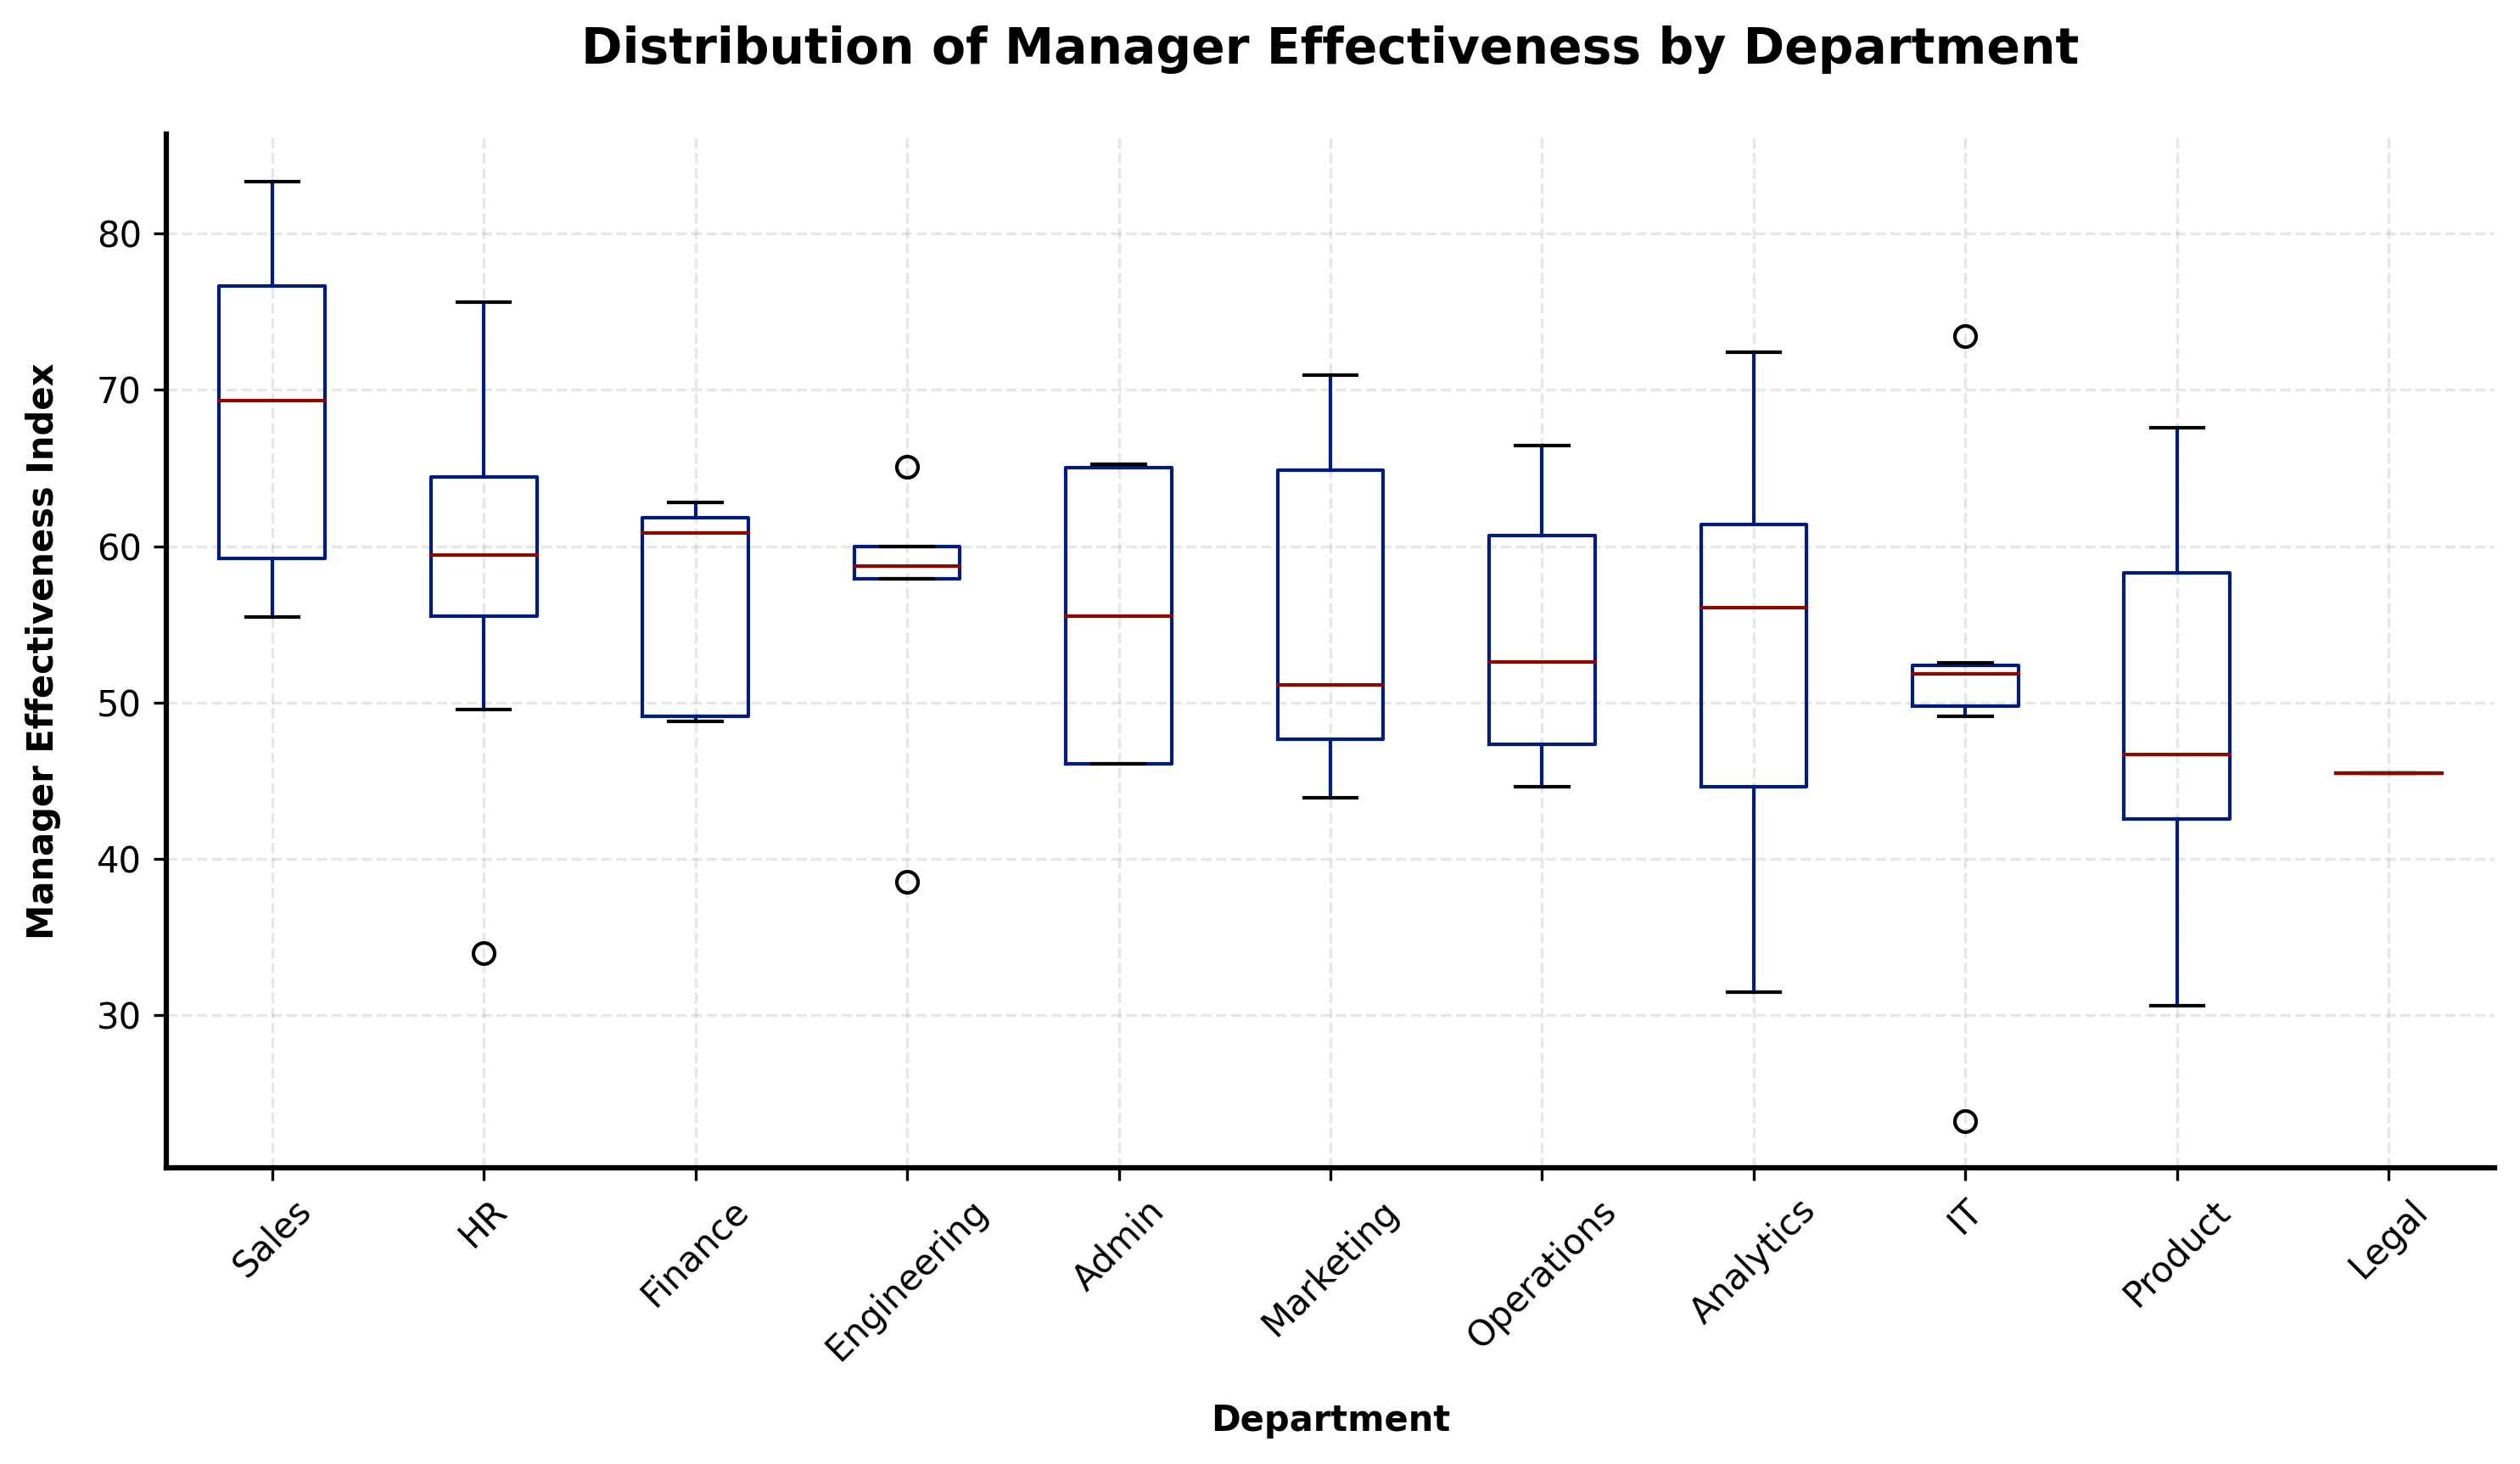

In [8]:
# Boxplot: Spread of scores by department
# Sort departments by descending mean before plotting
dept_order = final_sorted.groupby('department')['manager_effectiveness_index_100'].mean().sort_values(ascending=False).index

final_sorted['department'] = pd.Categorical(final_sorted['department'], categories=dept_order, ordered=True)

final_sorted.boxplot(column='manager_effectiveness_index_100', by='department', grid=True)
# Add labels and title
plt.ylabel('Manager Effectiveness Index')
plt.xlabel('Department')
plt.title('Distribution of Manager Effectiveness by Department')
plt.suptitle('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

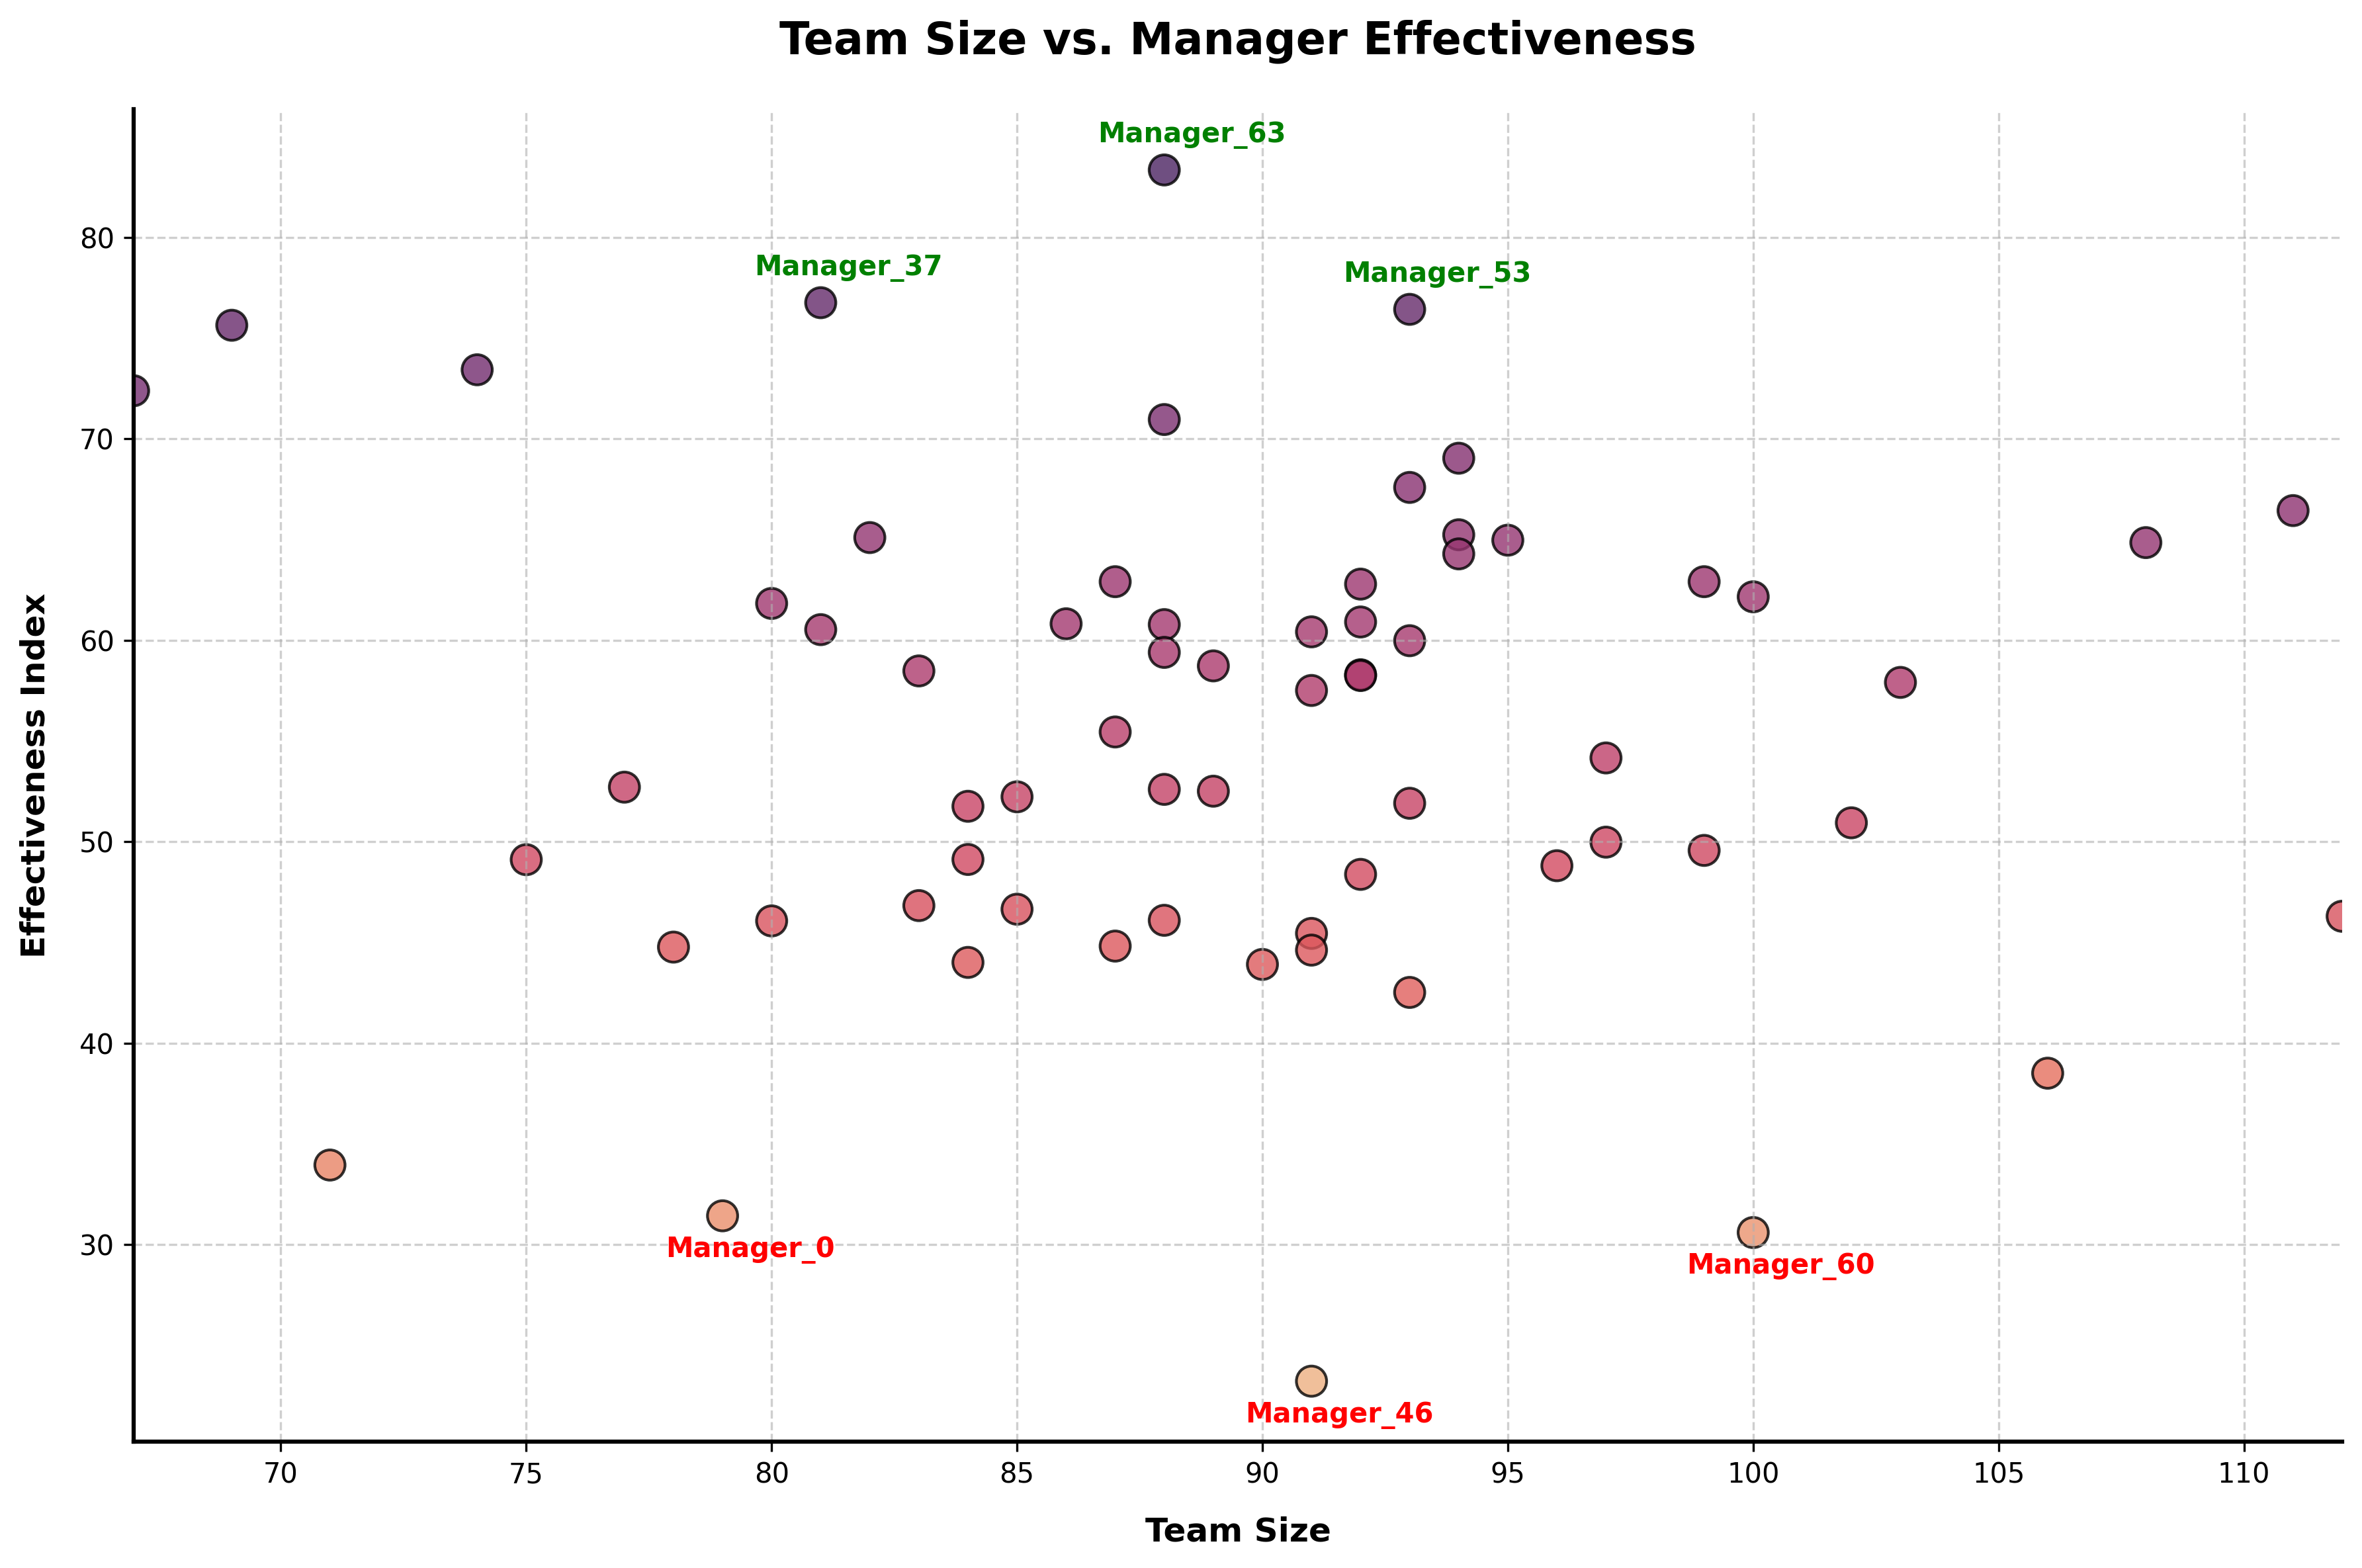

In [9]:
# Scatterplot: Team size vs. effectiveness with better color and insights
plt.figure(figsize=(12, 8))  # Increase figure size for better readability

# Scatterplot with enhanced styling
scatter = plt.scatter(
    final_sorted['team_size'], 
    final_sorted['manager_effectiveness_index_100'], 
    alpha=0.8, 
    c=final_sorted['manager_effectiveness_index_100'],  # Color by effectiveness index
    cmap='flare',  # Use a visually appealing colormap
    edgecolor='black',  # Add border to points for clarity
    s=120  # Increase marker size for better visibility
)

# Add labels and title
plt.title('Team Size vs. Manager Effectiveness', fontsize=16, weight='bold', pad=20)
plt.xlabel('Team Size', fontsize=12, weight='bold', labelpad=10)
plt.ylabel('Effectiveness Index', fontsize=12, weight='bold', labelpad=10)

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Highlight key insights with annotations
# Example: Highlight top and bottom managers
for i, row in top3.iterrows():
    plt.annotate(
        row['manager_name'], 
        (row['team_size'], row['manager_effectiveness_index_100']), 
        textcoords="offset points", xytext=(10, 10), ha='center', 
        fontsize=10, fontweight='bold', color='green'
    )

for i, row in bottom3.iterrows():
    plt.annotate(
        row['manager_name'], 
        (row['team_size'], row['manager_effectiveness_index_100']), 
        textcoords="offset points", xytext=(10, -15), ha='center', 
        fontsize=10, fontweight='bold', color='red'
    )

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

             mean    min    max  count
level                                 
Mid     55.970698  33.95  76.43     43
Senior  55.878824  30.60  83.35     17
Lead    50.682000  23.22  72.39      5


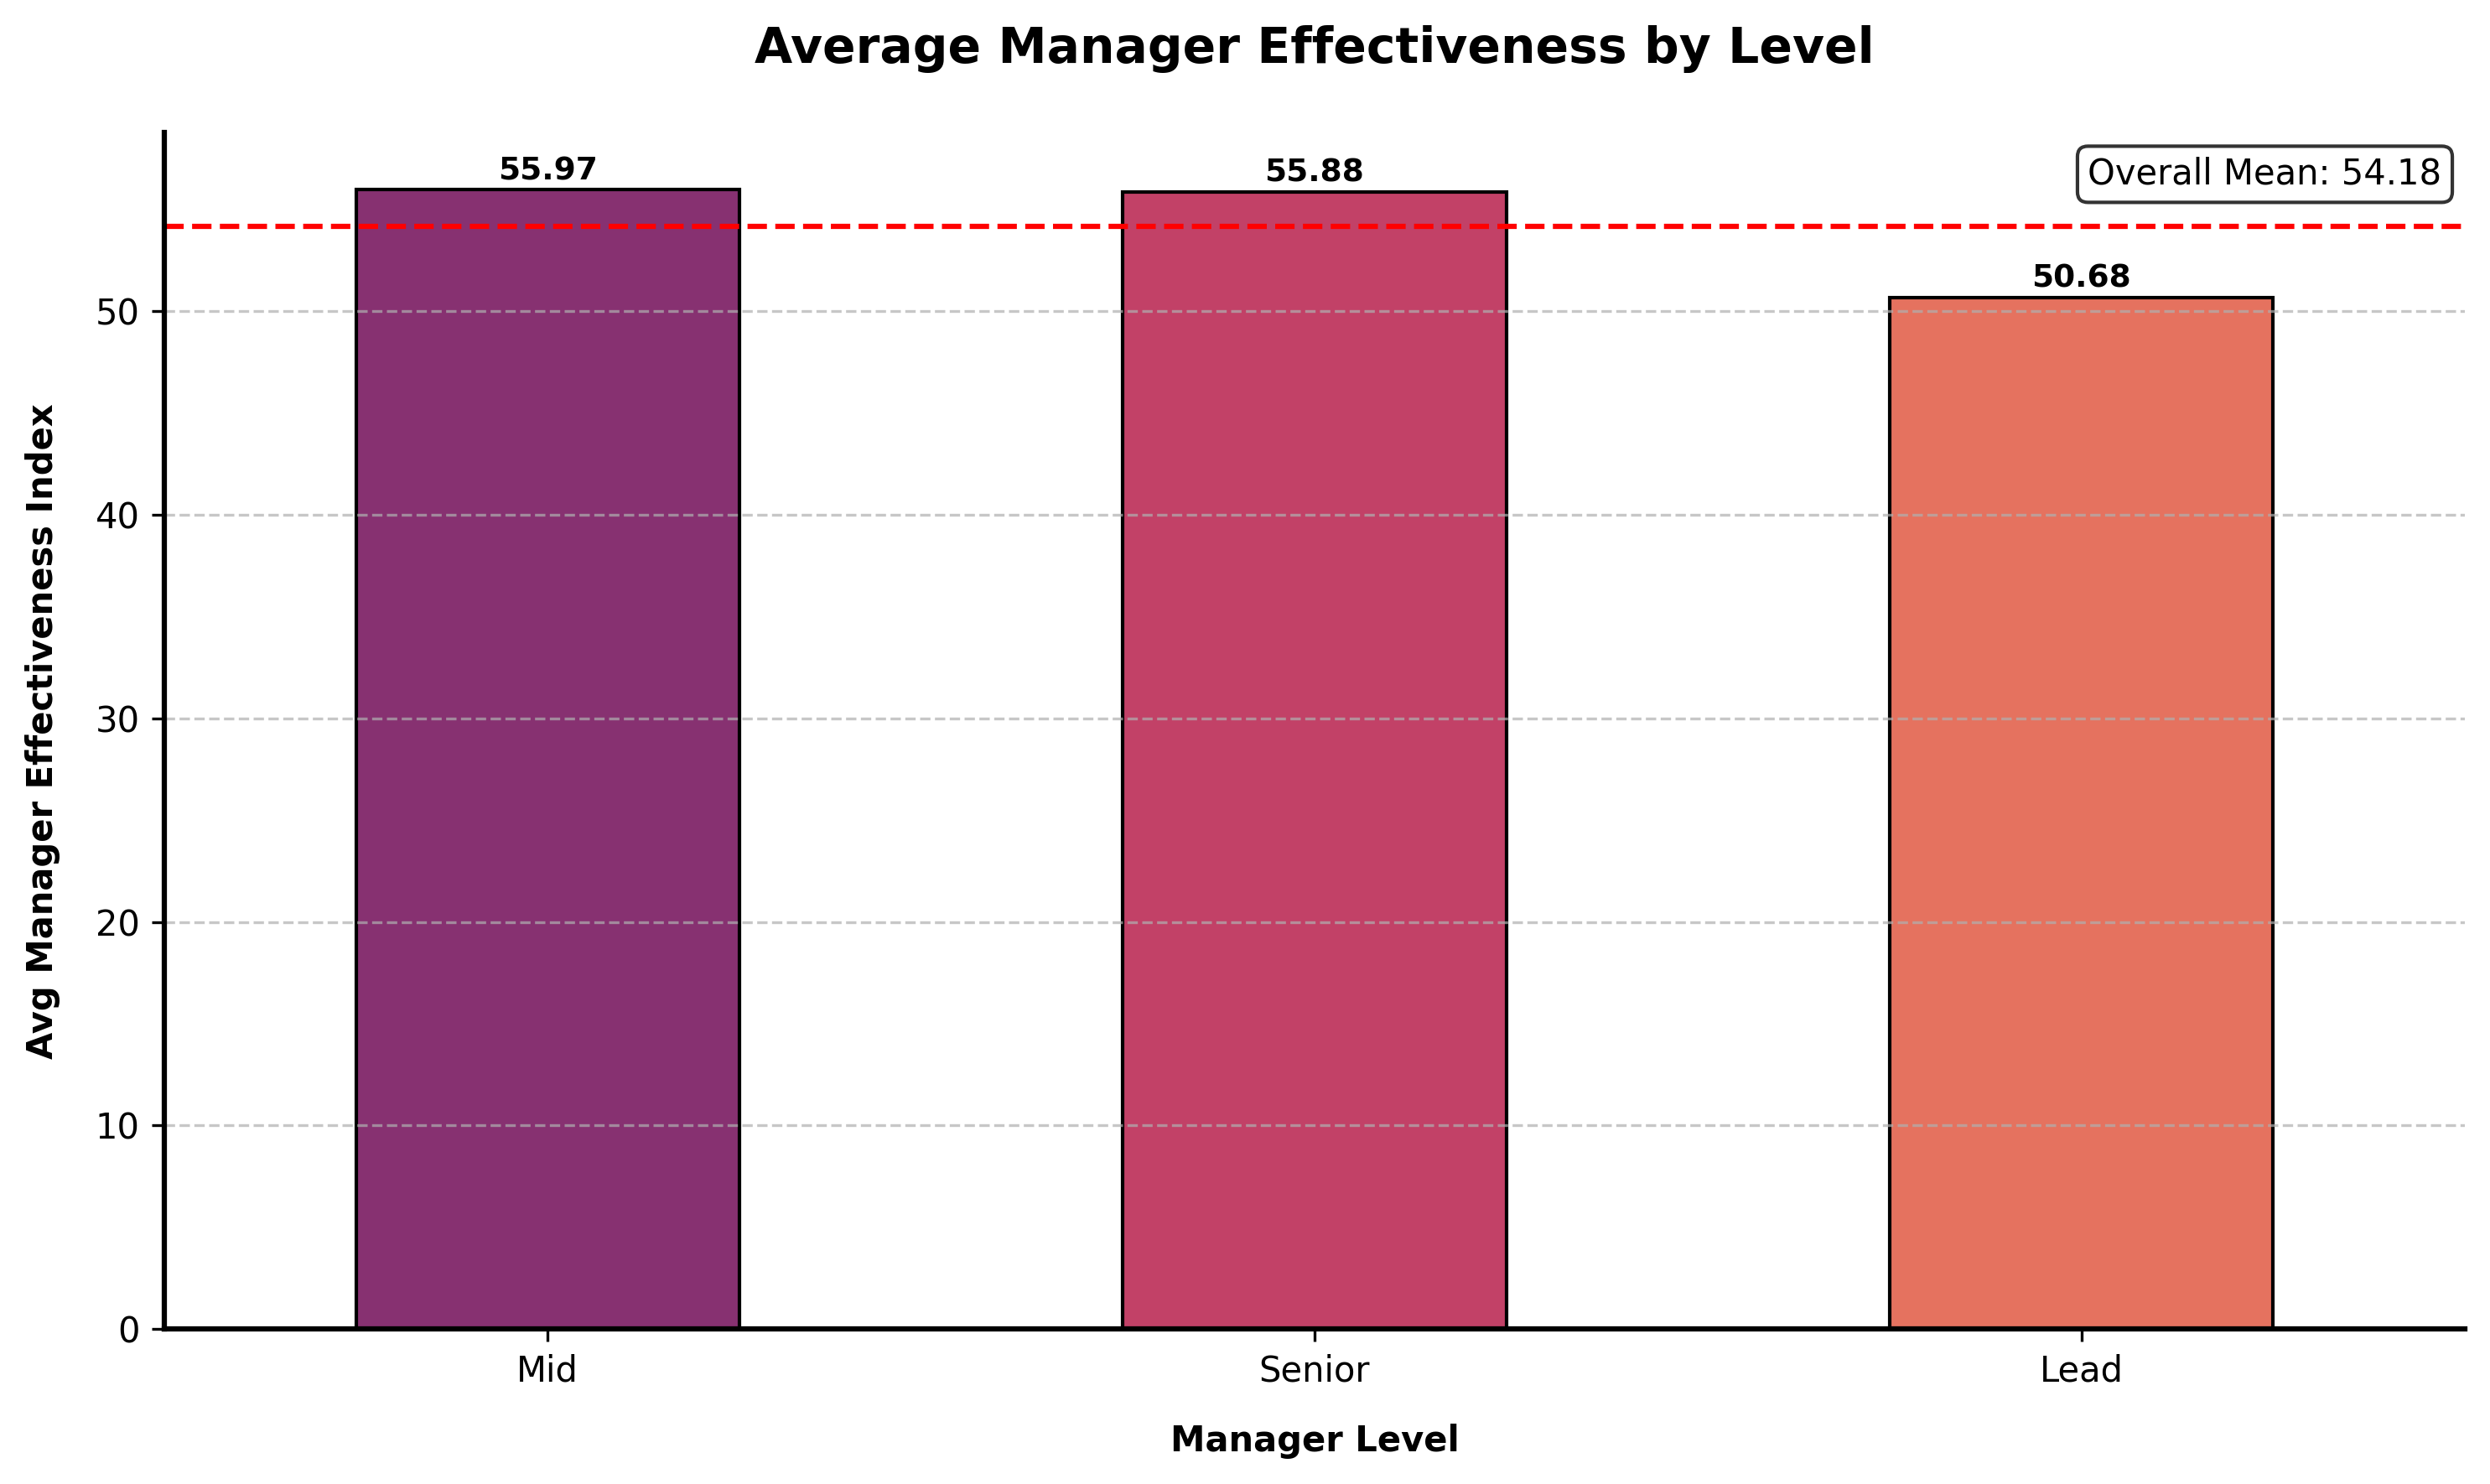

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate: Average effectiveness per manager level
level_summary = final_sorted.groupby('level')['manager_effectiveness_index_100'].agg(['mean', 'min', 'max', 'count']).sort_values('mean', ascending=False)
print(level_summary)

# Bar Chart: Average manager index by level
bar_colors = sns.color_palette("flare_r", len(level_summary))  # Use a visually appealing color palette
fig, ax = plt.subplots()

# Plot the bar chart
level_summary['mean'].plot(kind='bar', color=bar_colors, edgecolor='black', ax=ax)

# Add labels and title
ax.set_ylabel('Avg Manager Effectiveness Index', fontsize=10, fontweight='bold')
ax.set_xlabel('Manager Level', fontsize=10, fontweight='bold')
ax.set_title('Average Manager Effectiveness by Level', fontsize=14, fontweight='bold', pad=20)

# Customize x-axis ticks
ax.set_xticklabels(level_summary.index, rotation=0, fontsize=10, ha='center')

# Add gridlines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add value annotations on top of bars
for i, value in enumerate(level_summary['mean']):
    ax.text(i, value + 0.5, f'{value:.2f}', ha='center', fontsize=9, fontweight='bold', color='black')

# Add a horizontal line for the overall mean
overall_mean = level_summary['mean'].mean()
ax.axhline(overall_mean, color='red', linestyle='--', linewidth=1.5, label=f'Overall Mean: {overall_mean:.2f}')

# Add overall mean value in a text box
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
textstr = f'Overall Mean: {overall_mean:.2f}'
ax.text(0.99, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)


plt.tight_layout()
plt.show()

/tmp/ipykernel_44/3874357045.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


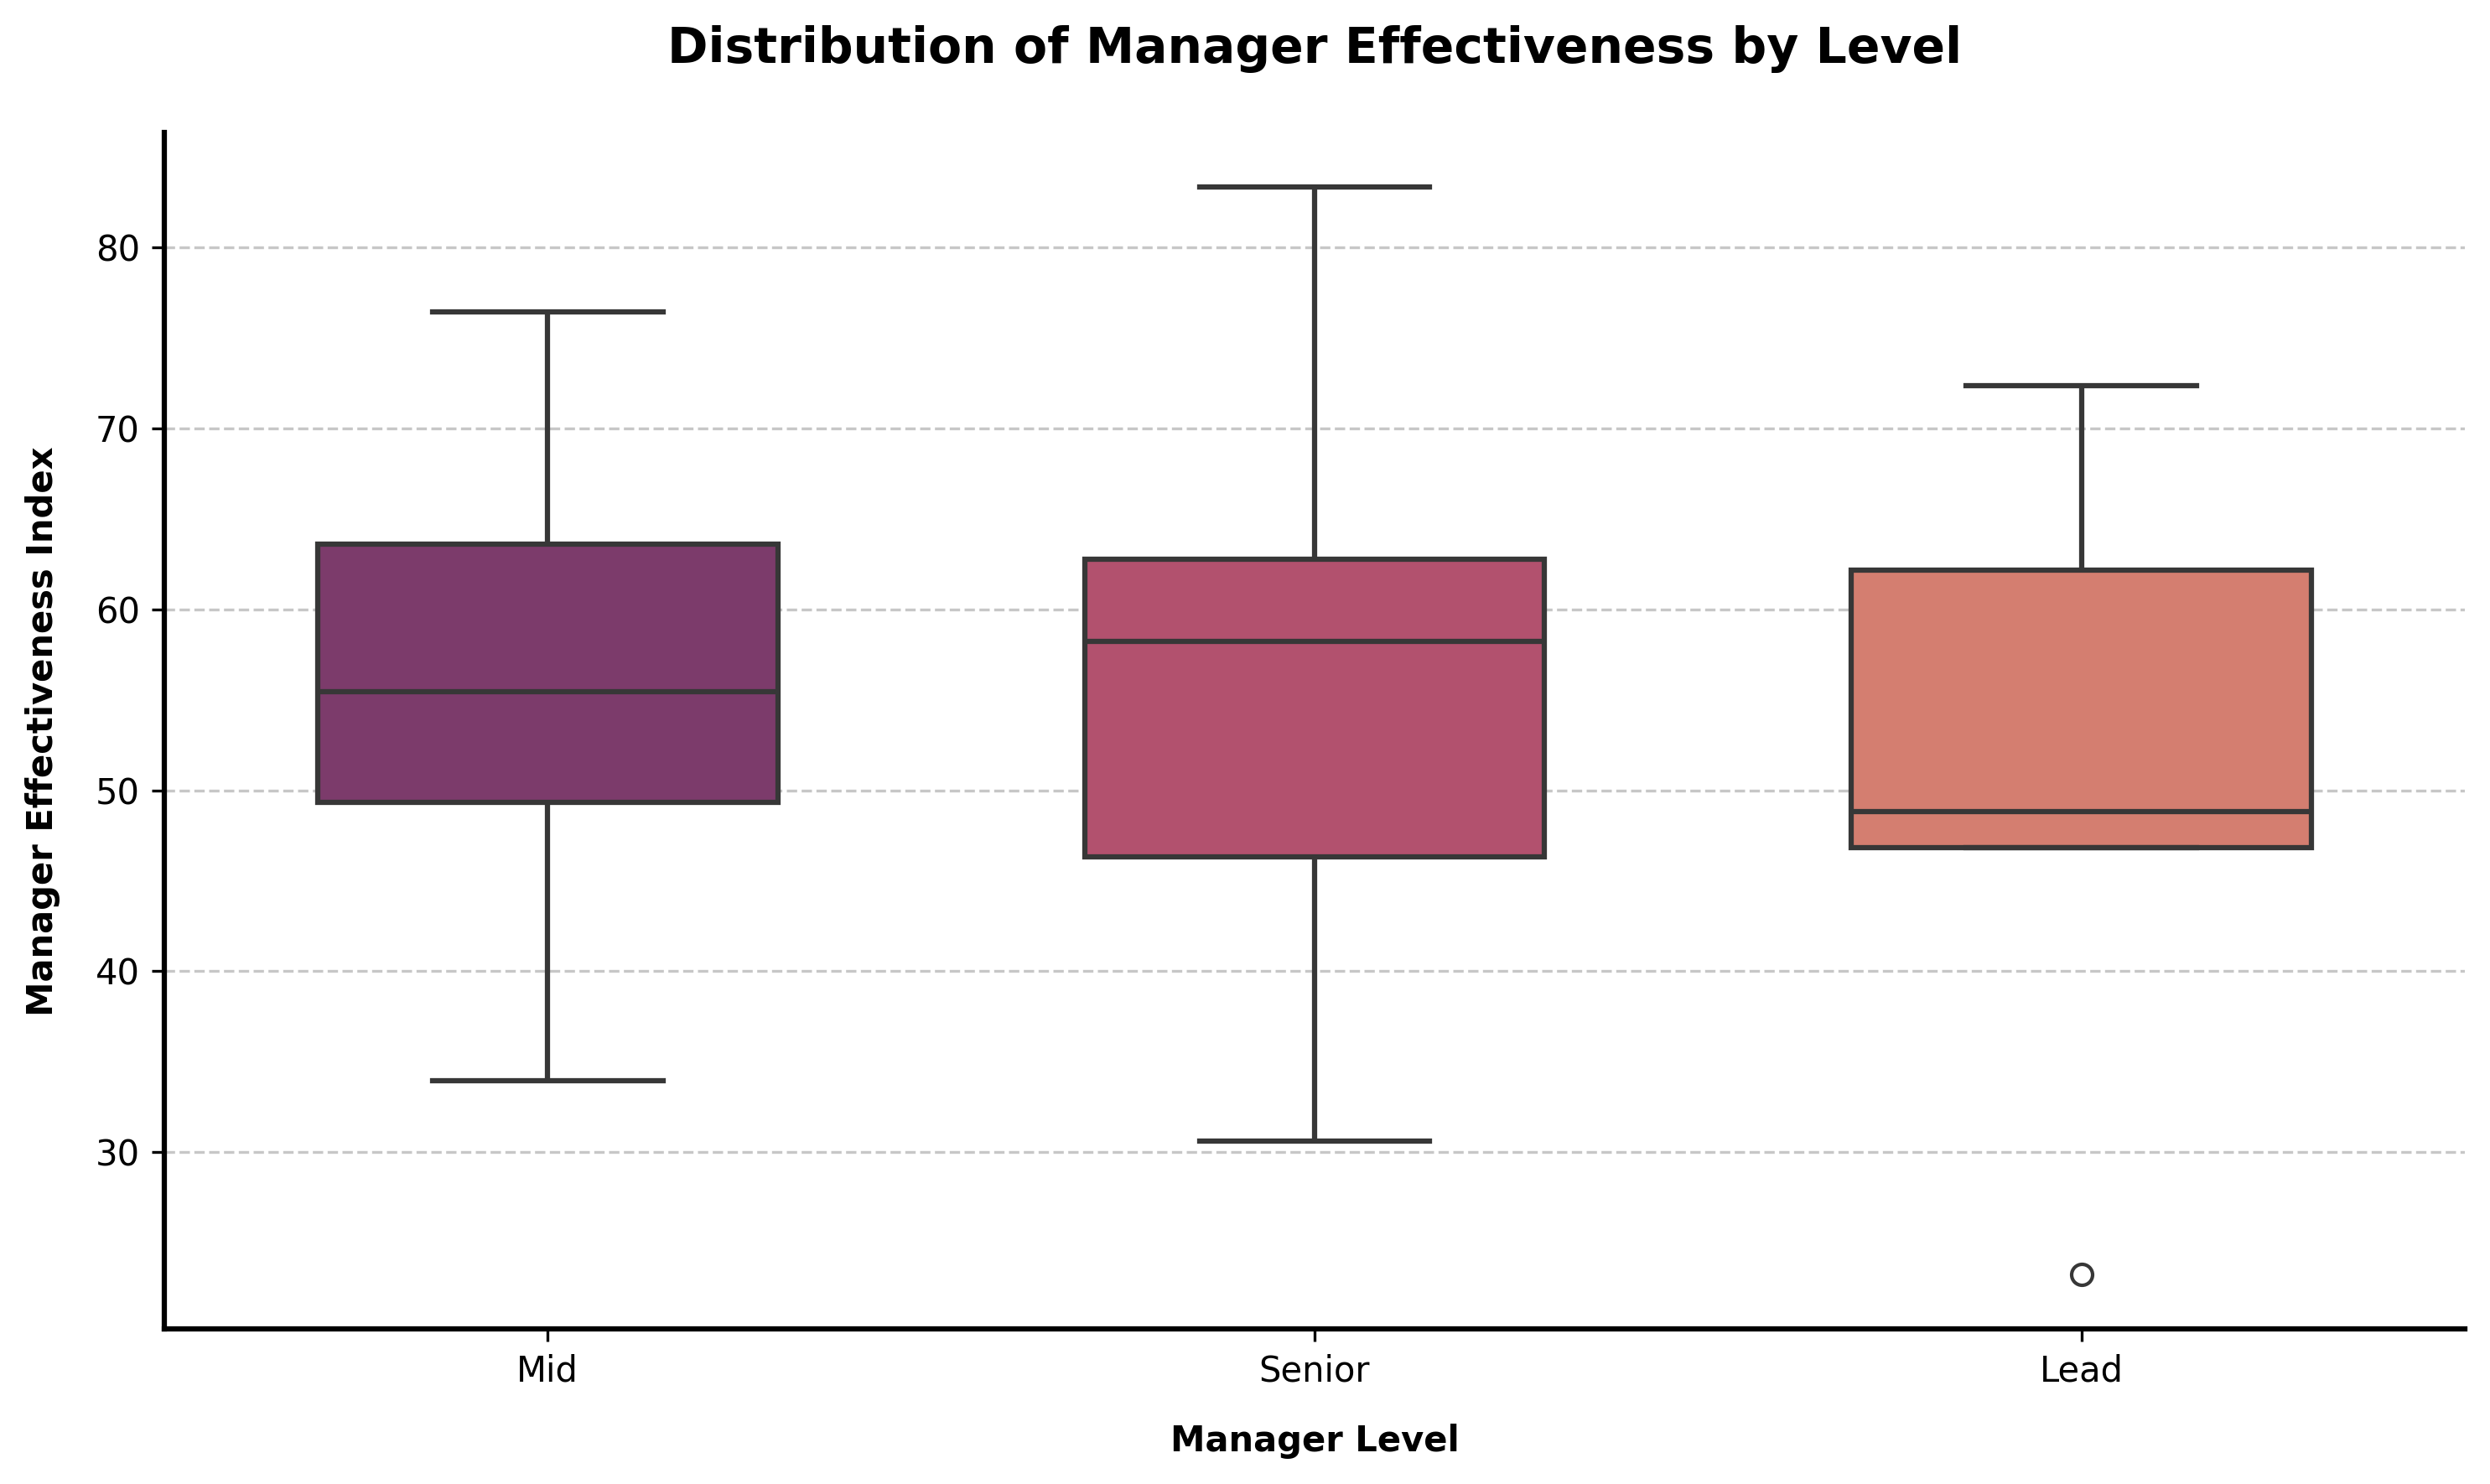

In [11]:
# Improved Boxplot: Spread by level
import seaborn as sns
import matplotlib.pyplot as plt

# Arrange levels in the desired order
level_order = ['Mid', 'Senior', 'Lead']
final_sorted['level'] = pd.Categorical(final_sorted['level'], categories=level_order, ordered=True)

# Create a boxplot with enhanced styling
sns.boxplot(
    data=final_sorted, 
    x='level', 
    y='manager_effectiveness_index_100', 
    palette='flare_r',  # Use a visually appealing color palette
    linewidth=1.5,  # Thicker lines for better visibility
    width=0.6  # Adjust box width for aesthetics
)

# Add labels and title
plt.ylabel('Manager Effectiveness Index')
plt.xlabel('Manager Level')
plt.title('Distribution of Manager Effectiveness by Level')

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customize x-axis ticks
plt.xticks(fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [12]:
# Aggregate: Correlation between team size and effectiveness
corr = final_sorted['team_size'].corr(final_sorted['manager_effectiveness_index_100'])
print(f"Correlation between team size and manager effectiveness: {corr:.2f}")

# Identify extremes (optional)
largest_team = final_sorted.loc[final_sorted['team_size'].idxmax()]
smallest_team = final_sorted.loc[final_sorted['team_size'].idxmin()]
print("Largest team manager:", largest_team['manager_name'], largest_team['team_size'], largest_team['manager_effectiveness_index_100'])
print("Smallest team manager:", smallest_team['manager_name'], smallest_team['team_size'], smallest_team['manager_effectiveness_index_100'])


Correlation between team size and manager effectiveness: -0.06
Largest team manager: Manager_36 112 46.3
Smallest team manager: Manager_15 67 72.39


> create summary scorecard and create visual

In [24]:
# Create a summary scorecard
summary_scorecard = {
    'Top Manager': top3.iloc[0]['manager_name'],
    'Top Manager Effectiveness': top3.iloc[0]['manager_effectiveness_index_100'],
    'Bottom Manager': bottom3.iloc[0]['manager_name'],
    'Bottom Manager Effectiveness': bottom3.iloc[0]['manager_effectiveness_index_100'],
    'Overall Mean Effectiveness': overall_mean,
    'Correlation (Team Size vs Effectiveness)': corr,
    'Largest Team Manager': largest_team['manager_name'],
    'Largest Team Size': largest_team['team_size'],
    'Largest Team Effectiveness': largest_team['manager_effectiveness_index_100'],
    'Smallest Team Manager': smallest_team['manager_name'],
    'Smallest Team Size': smallest_team['team_size'],
    'Smallest Team Effectiveness': smallest_team['manager_effectiveness_index_100']
}

# Display the scorecard
summary_scorecard

{'Top Manager': 'Manager_63',
 'Top Manager Effectiveness': 83.35,
 'Bottom Manager': 'Manager_46',
 'Bottom Manager Effectiveness': 23.22,
 'Overall Mean Effectiveness': 54.17717373461013,
 'Correlation (Team Size vs Effectiveness)': -0.06452221732127168,
 'Largest Team Manager': 'Manager_36',
 'Largest Team Size': 112,
 'Largest Team Effectiveness': 46.3,
 'Smallest Team Manager': 'Manager_15',
 'Smallest Team Size': 67,
 'Smallest Team Effectiveness': 72.39}

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=de60fd44-99b7-4fb5-aa5a-bb31c1f0e33a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>